In [1]:
import numpy as np

In [2]:
import os

In [3]:
import ntpath

In [4]:
import scipy.optimize as spopt

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as col

In [6]:
from power_spec import power_spec as ps

In [7]:
from cpw_resonator import cpw_resonator as cpw

In [8]:
from qkit.analysis.resonator import Resonator as Resonator

In [9]:
from qkit.analysis import dat_reader as dat

In [10]:
from qkit.analysis.circle_fit.circuit import reflection_singleport as rf_p
from qkit.analysis.circle_fit.circuit import reflection_port as rf

In [11]:
import scipy.constants as cs

In [12]:
%matplotlib inline

In [13]:
from qkit.storage import hdf_lib

In [14]:
import tvregdiff as tv

In [15]:
import random

In [16]:
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage.filters import median_filter

In [17]:
font = {'weight' : 'normal', 'size' : 22}
plt.rc('font', **font)
labelsize=30

In [18]:
h = cs.h
e = cs.e

In [19]:
phi_0 = cs.codata.value('magn. flux quantum')

In [20]:
R_k = h/(2.*e**2.)

In [21]:
    def _fit_skewed_lorentzian(f_data,amplitude, ignoreslope = False):
        '''
        - calculates the linear background slope with the first x and the last x percent of the data points
        as the start value for the fit
        - substracts the linear background from the data set to find the real minimum of the resonance (not identical to the 
        overall minimum if the tilt is large and the internal quality factor is high)
        '''
        
        amplitude = gaussian_filter1d(amplitude,6)
        A1a = np.minimum(amplitude[0],amplitude[-1]) 
        #A3a = -(np.max(amplitude_sqr)-np.min(amplitude_sqr))       

        if ignoreslope == False:
            m = rf_p._background(f_data, amplitude, 2., gauss_filter = True)      #x = 2.
            tilt = m*f_data-m*f_data[0]              
            A3a = np.max(amplitude-tilt)
            fra = f_data[np.argmax(amplitude-tilt)]
            
        else:
            A3a = np.max(amplitude)
            fra = f_data[np.argmax(amplitude)]
            m = 0.                                      #starting value is m = 0.
            
        def residuals(p,x,y):
            A2, A4, Ql = p
            err = y -(A1a+A2*(x-fra)+(A3a+A4*(x-fra))/(1.+4.*Ql**2*((x-fra)/fra)**2))
            return err
        p0 = [m, 0., 1500.]
        p_final = spopt.leastsq(residuals,p0,args=(np.array(f_data),np.array(amplitude)))
        A2a, A4a, Qla = p_final[0]
    
        def residuals2(p,x,y):
            A1, A2, A3, A4, fr, Ql = p
            err = y -(A1+A2*(x-fr)+(A3+A4*(x-fr))/(1.+4.*Ql**2*((x-fr)/fr)**2))
            return err
        p0 = [A1a, A2a , A3a, A4a, fra, Qla]
        p_final = spopt.leastsq(residuals2,p0,args=(np.array(f_data),np.array(amplitude)))
        #A1, A2, A3, A4, fr, Ql = p_final[0]
        #print p_final[0][5]
        return p_final[0]

# resonator parameters: 

In [22]:
cpw_res = cpw(10e-6, 6e-6, 2800e-6, 7.47e-15)

In [23]:
alpha_0 = np.pi**2.*cpw_res._wresc*50/R_k

In [24]:
powerpath = "C:/Users/Patrick/Documents/JPA/Mask #3/data/20160407/120624_2D_VNA_tracedata/120624_2D_VNA_tracedata.h5"
#powerpath = "C:/Users/Patrick/Documents/JPA/Mask #3/data/20160407/115511_2D_VNA_tracedata/115511_2D_VNA_tracedata.h5"
#powerpath = "C:/Users/Patrick/Documents/JPA/Mask #3/data/20160407/120624_2D_VNA_tracedata/120624_2D_VNA_tracedata.h5"

In [25]:
data=hdf_lib.Data(path=powerpath)

In [26]:
#filename_ext = os.path.basename(powerpath)

In [27]:
#filename = os.path.splitext(filename_ext)[0]

In [28]:
powerspec = ps(powerpath, gaussfilter = False)

no change - attenuation already: 0 dB


In [29]:
powerspec2 = ps(powerpath, gaussfilter = True)

no change - attenuation already: 0 dB


In [30]:
attenuation = 120

In [31]:
powerspec._set_attenuation(attenuation)
powerspec2._set_attenuation(attenuation)

In [32]:
powerspec2._set_gauss_nmb(1.)
powerspec2._prep_data(gaussfilter = True)

no change - attenuation already: 120 dB


In [33]:
#powerspec._get_window()

In [34]:
#powerspec._set_window(True)

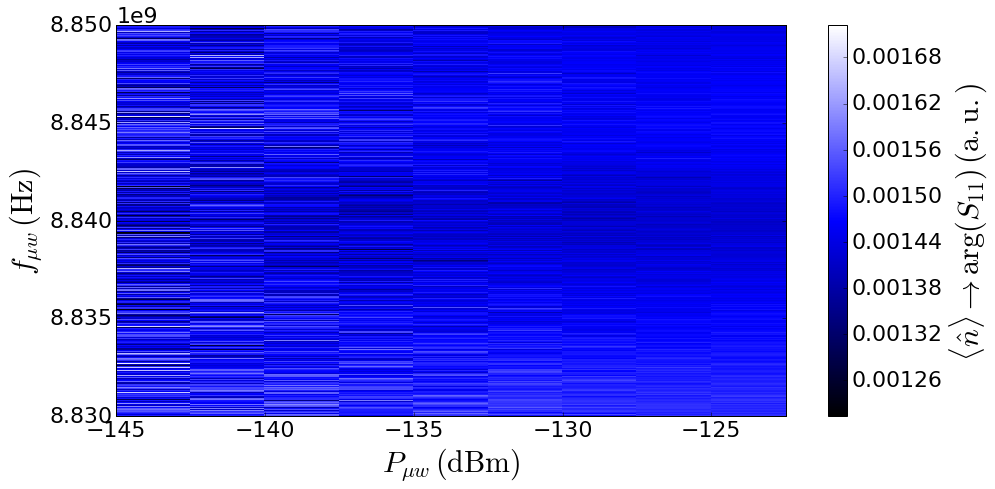

In [35]:
powerspec._plot_amp(norm = False, save = False)

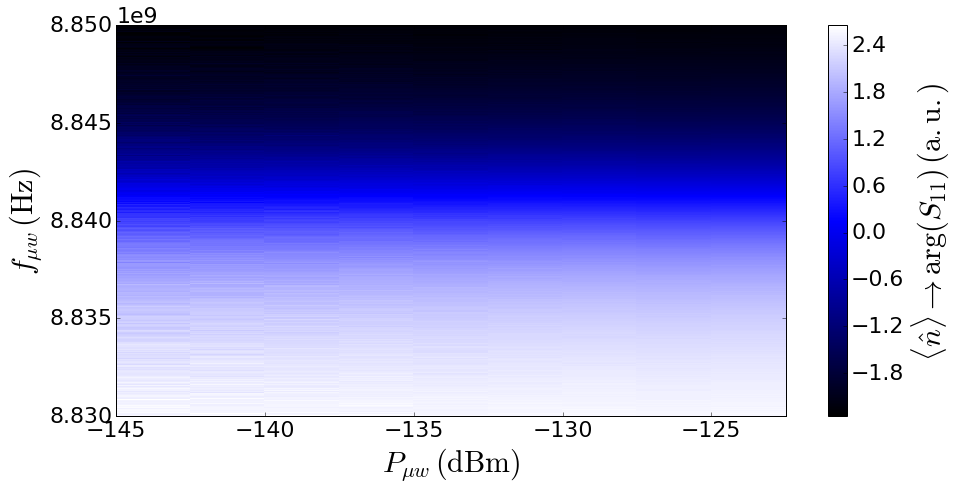

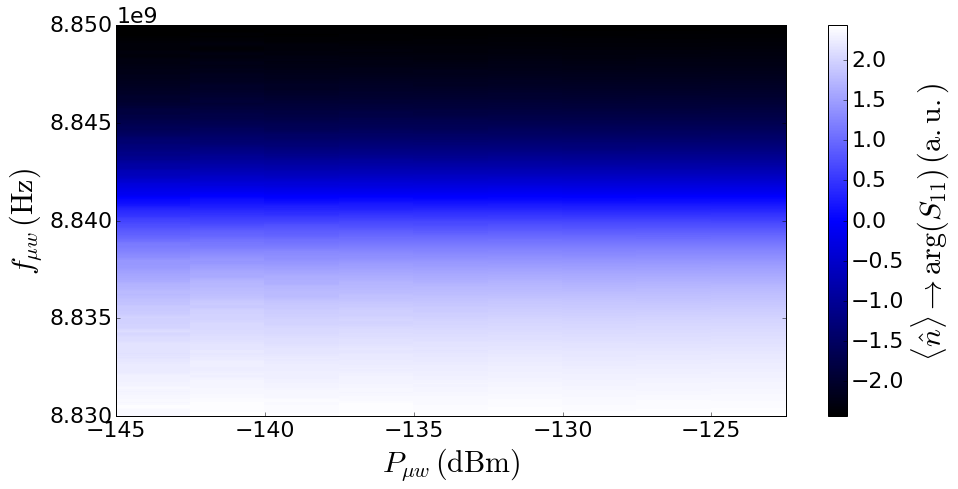

In [36]:
powerspec._plot_phase(norm = False, save = False)
powerspec2._plot_phase(norm = True, save = False)

fr (phase derivation) = 8842172416.0
fr (phase derivation) = 8841992192.0
fr (phase derivation) = 8841831424.0
fr (phase derivation) = 8841831424.0
fr (phase derivation) = 8841971712.0
fr (phase derivation) = 8841611264.0
fr (phase derivation) = 8842011648.0
fr (phase derivation) = 8842151936.0
fr (phase derivation) = 8841971712.0
fr (phase derivation) = 8841772032.0


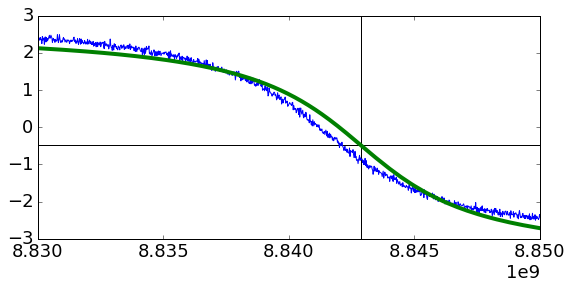

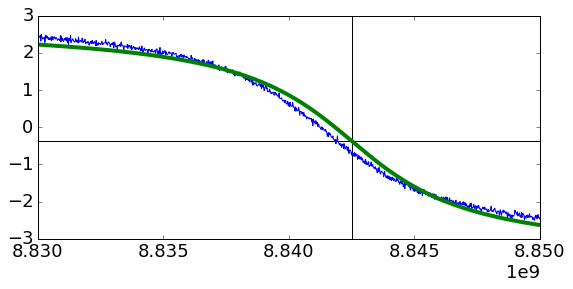

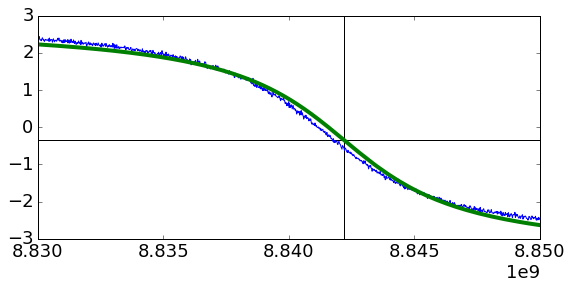

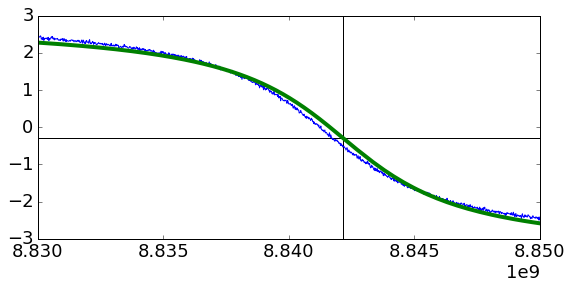

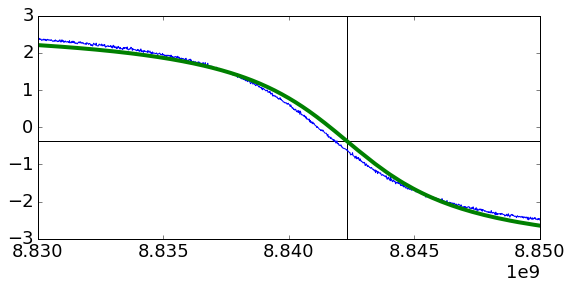

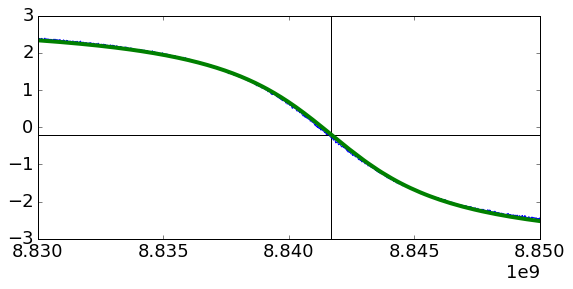

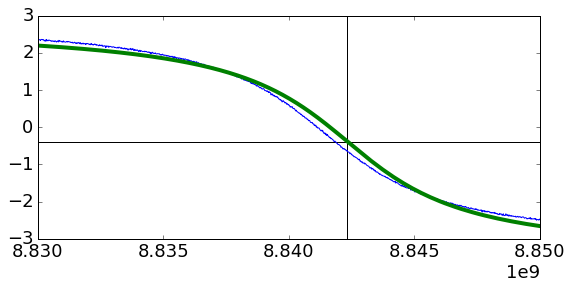

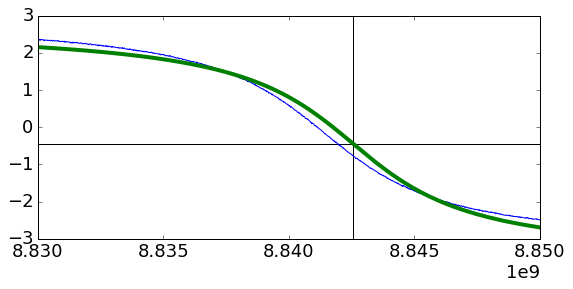

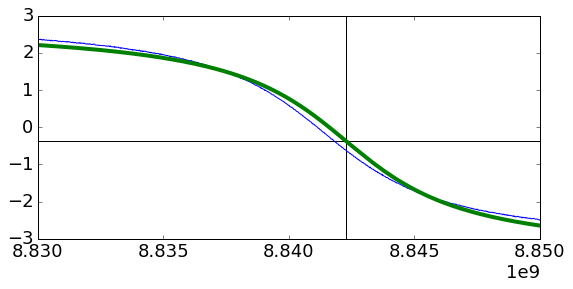

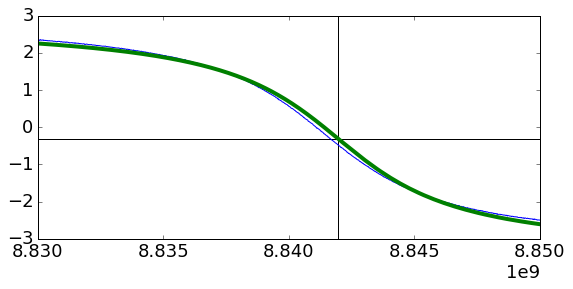

In [37]:
for i in range(len(powerspec._power)):
    cf = rf_p(powerspec._freq, powerspec._z_data_raw[i])
    fr, sign = cf._phase_fr_sign(powerspec._freq, np.unwrap(np.angle(powerspec._z_data_raw[i])), 3, 20)
    theta0 = cf._theta0_start(powerspec._freq,np.unwrap(np.angle(powerspec._z_data_raw[i])), fr)
    theta0, Ql, fr = cf._phase_fit(powerspec._freq, powerspec._z_data_raw[i], 0.1, 1200, fr, 1, overcoupled = True)
    fig, axes = plt.subplots(figsize = (9,4))
    axes.axhline(theta0, color = 'black')
    axes.axvline(fr, color = 'black')
    phase = cf.phase_fitfunction(powerspec._freq, theta0, Ql, fr, 0., 1., overcoupled = True)[0]
    #axes.plot(powerspec._freq, powerspec._phase_n.T[i], lw = 2)
    axes.plot(powerspec._freq, np.angle(powerspec._z_data_raw[i]))
    axes.plot(powerspec._freq, phase, lw = 4)
    #axes.plot(powerspec._freq, np.angle(z_data_sim[i]), lw = 2, color = 'red')

fr (phase derivation) = 8841992192.0
get delay
theta_0 = -0.264069998022, fr = 8841992192.0, Ql = 1000.0, sign = 1.0, slope = 3.54575494613e-08
agebraic r0: 0.00146840312926
iterative r0: 0.00145210514519
zc = (-3.13059726601e-05-2.04985391101e-06j)
calibration: Theta0 -0.356208620198


C:\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


agebraic r0: 0.991601073668
iterative r0: 0.98063322566
3.13314726891
phi_0 = -0.00844538468043
fr (phase derivation) = 8841992192.0


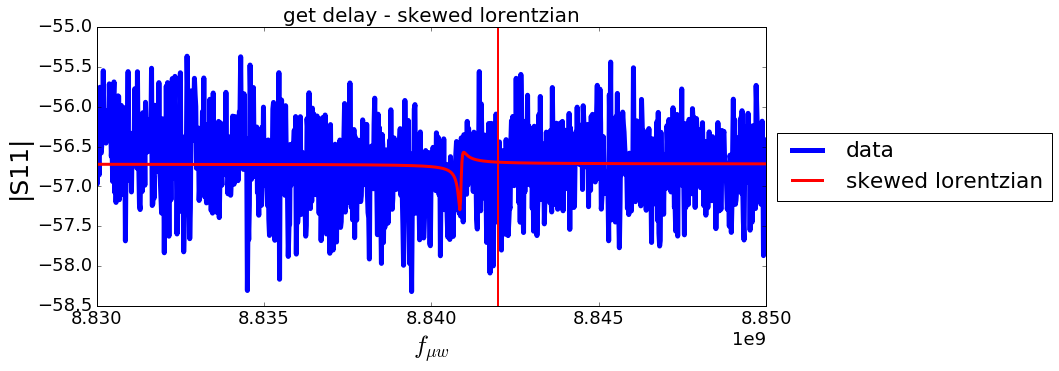

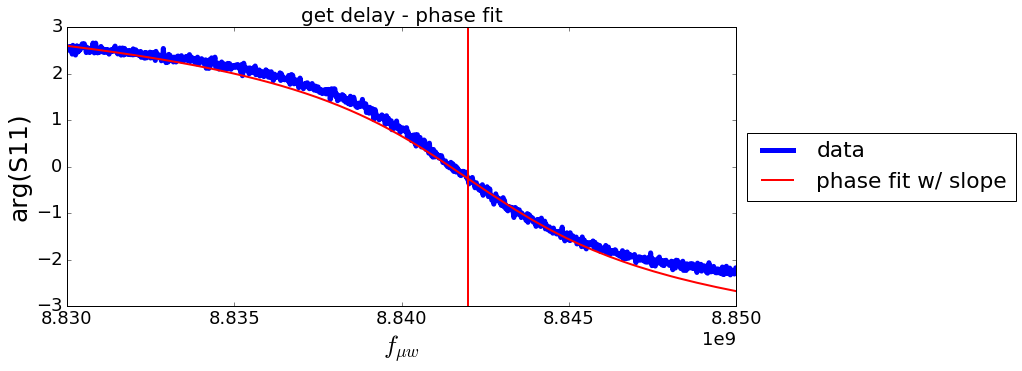

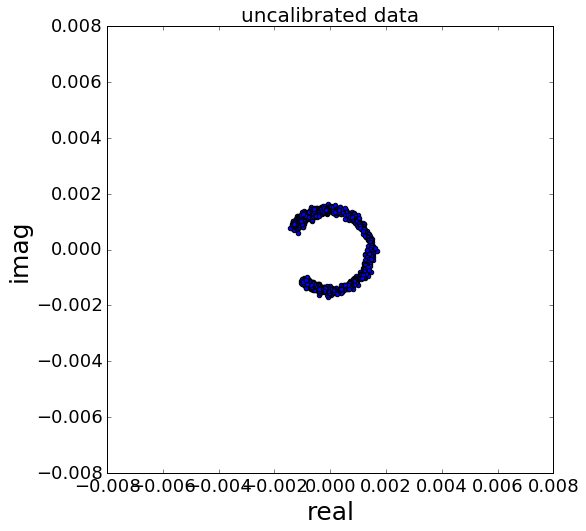

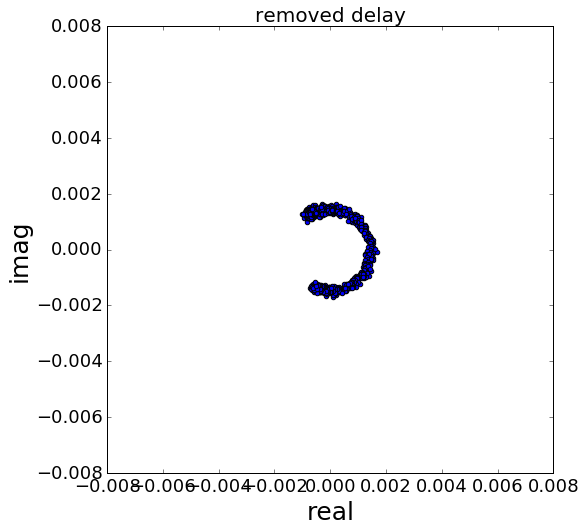

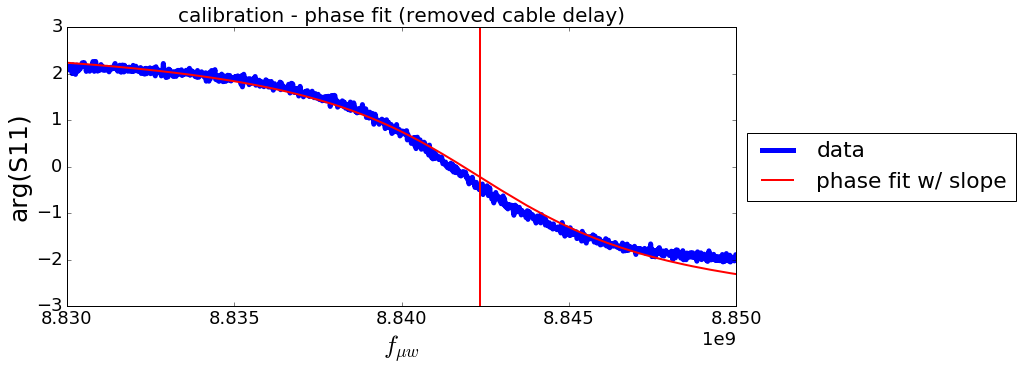

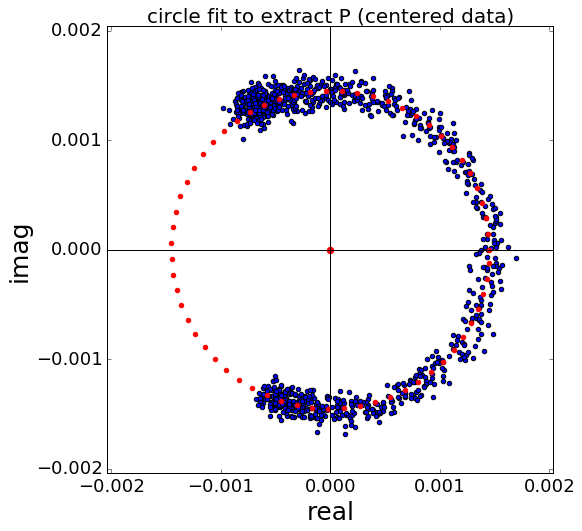

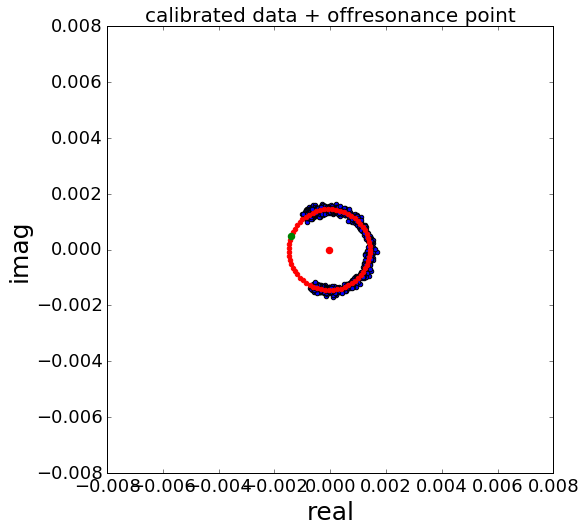

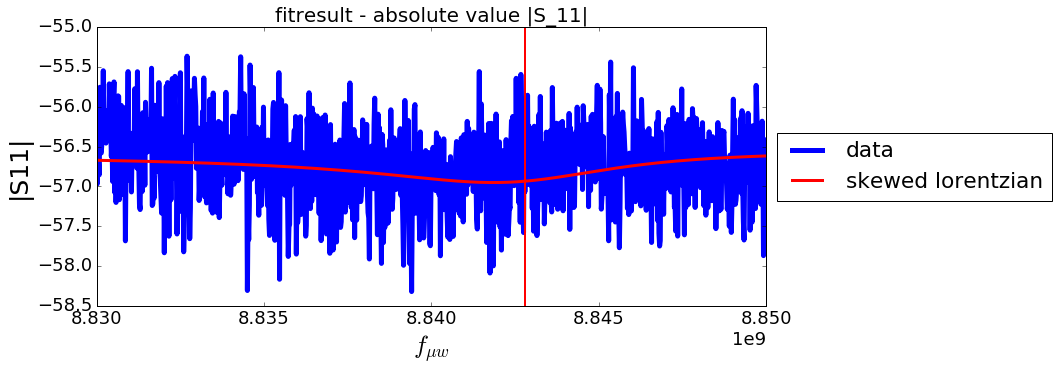

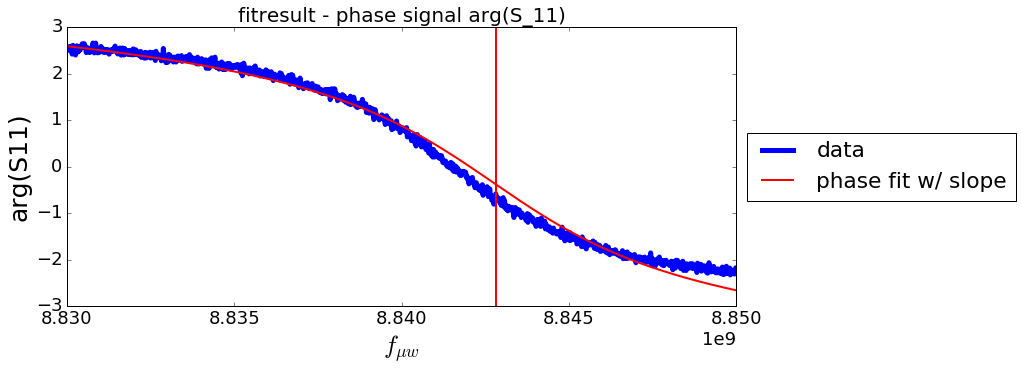

In [42]:
'''circle fit routine for every power value'''
fres_cal = []
fres_pf = []
chi_sqr = []
Qloaded = []
Qload_pf = []
z_data_sim = []
for i in range(1):
    powerspec._get_data_circle(norm = False)
    cf = rf_p(powerspec._freq, powerspec._z_data_raw[i])
    cf.set_theta0(None)
    cf.set_Ql(1000)
    cf.autofit(coupling = 'overcoupled', ignoreslope = True, refine_res = True, plot = True)
    _fr, sign = cf._phase_fr_sign(powerspec._freq, np.unwrap(np.angle(powerspec._z_data_raw[i])))
    theta0, Ql, fr, slope = cf._phase_fit_wslope(powerspec._freq, powerspec._z_data_raw[i], 0, 1000, _fr, 0., 1.)
    z_data_sim.append(cf.z_data_sim)
    fitresults = cf.fitresults
    fres_cal.append(fitresults['fr'])
    fres_pf.append(fr)
    chi_sqr.append(fitresults['chi_square'])
    Qloaded.append(fitresults['Ql'])
    Qload_pf.append(Ql)

In [39]:
len(powerspec._power)

10

In [53]:
cf = rf_p(powerspec._freq, powerspec._z_data_raw[9])

In [54]:
cf.set_theta0(0)

In [55]:
cf.autofit(coupling = 'overcoupled', ignoreslope = False, refine_res = True, plot = False)

fr (phase derivation) = 8841732096.0
agebraic r0: 0.00145179016932
iterative r0: 0.00145138883198
zc = (-3.02886883845e-05-1.37460201017e-05j)
calibration: Theta0 -0.0896803830629
agebraic r0: 0.980543336833
iterative r0: 0.980271361873
3.13055873293
phi_0 = -0.0110339206579


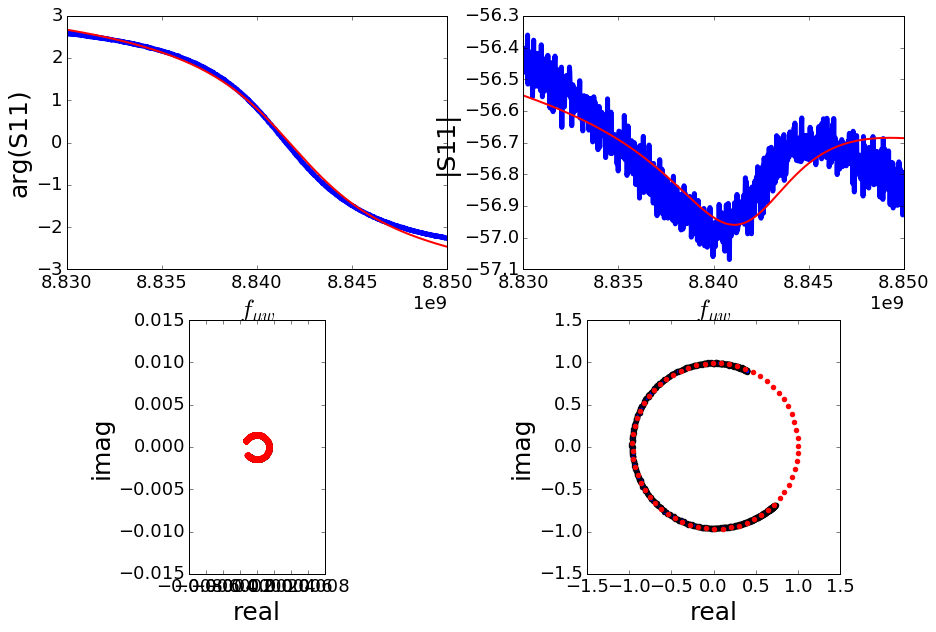

In [58]:
cf.plot_all()

In [59]:
'''circle fit routine for every power value'''
fres_cal = []
fres_pf = []
chi_sqr = []
Qloaded = []
Qload_pf = []
z_data_sim = []
for i in range(len(powerspec._power)):
    powerspec._get_data_circle(norm = False)
    cf = rf_p(powerspec._freq, powerspec._z_data_raw[i])
    cf.autofit(coupling = 'overcoupled', ignoreslope = False, refine_res = True, plot = False)
    _fr, sign = cf._phase_fr_sign(powerspec._freq, np.unwrap(np.angle(powerspec._z_data_raw[i])))
    theta0, Ql, fr, slope = cf._phase_fit_wslope(powerspec._freq, powerspec._z_data_raw[i], 0, 1000, _fr, 0., 1.)
    z_data_sim.append(cf.z_data_sim)
    fitresults = cf.fitresults
    fres_cal.append(fitresults['fr'])
    fres_pf.append(fr)
    chi_sqr.append(fitresults['chi_square'])
    Qloaded.append(fitresults['Ql'])
    Qload_pf.append(Ql)

C:\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(errors[info][0], RuntimeWarning)


fr (phase derivation) = 8841992192.0
agebraic r0: 0.00146217562168
iterative r0: 0.0014461427604
zc = (-2.38197132793e-05-2.43785538787e-05j)
calibration: Theta0 -0.200399389035
agebraic r0: 0.998030835136
iterative r0: 0.987080256278
3.12209452436
phi_0 = -0.0194981292263
fr (phase derivation) = 8841992192.0
fr (phase derivation) = 8841831424.0
agebraic r0: 0.00146078416886
iterative r0: 0.00145034476967
zc = (-3.0270372652e-05-1.37836076879e-05j)
calibration: Theta0 -0.211016284494
agebraic r0: 0.988801567815
iterative r0: 0.981774626865
3.12818043668
phi_0 = -0.0134122169119
fr (phase derivation) = 8841851904.0
fr (phase derivation) = 8841451520.0
agebraic r0: 0.00146080775046
iterative r0: 0.00145516699983
zc = (-3.11769537391e-05-3.85322519132e-05j)
calibration: Theta0 0.0261639633704
agebraic r0: 0.981652959971
iterative r0: 0.977895465338
3.11626347549
phi_0 = -0.0253291781001
fr (phase derivation) = 8841912320.0
fr (phase derivation) = 8841751552.0
agebraic r0: 0.00144751715249

C:\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: ftol=0.000000 is too small, no further reduction in the sum of squares
  is possible.
  warnings.warn(errors[info][0], RuntimeWarning)


fr (phase derivation) = 8841912320.0
agebraic r0: 0.00144443939663
iterative r0: 0.00144381041933
zc = (-2.15885970079e-05-4.56262024268e-05j)
calibration: Theta0 -0.135551766301
agebraic r0: 0.989048429254
iterative r0: 0.988617133857
3.10861479205
phi_0 = -0.0329778615405
fr (phase derivation) = 8841912320.0
fr (phase derivation) = 8842032128.0
agebraic r0: 0.0014500227155
iterative r0: 0.00144962197121
zc = (-2.78928136579e-05-2.74505110604e-05j)
calibration: Theta0 -0.2030949518
agebraic r0: 0.985015692528
iterative r0: 0.984743066275
3.11951855138
phi_0 = -0.0220741022091
fr (phase derivation) = 8841732096.0
fr (phase derivation) = 8841732096.0
agebraic r0: 0.00145157239515
iterative r0: 0.00145136850774
zc = (-2.07755469273e-05-4.18152370179e-05j)
calibration: Theta0 -0.0828061470615
agebraic r0: 0.987590187733
iterative r0: 0.98745162238
3.11205537827
phi_0 = -0.0295372753159
fr (phase derivation) = 8841931776.0
fr (phase derivation) = 8841732096.0
agebraic r0: 0.00145179016932


In [ ]:
fig, axes = plt.subplots(figsize = (10,6))
axes.plot(powerspec._power,Qloaded, label = r'$Q_L$ (circle fit)', lw = 2, color = 'blue')
axes.plot(powerspec._power,Qload_pf, label = r'$Q_L$ (phase fit)', lw = 2, color = 'green')
axes.set_ylabel(r'$\mathrm{quality factor}\,\,Q_l$ [Hz]', fontsize = labelsize)
axes.set_xlabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize= labelsize)

In [ ]:
fres_cal = np.array(fres_cal)
mask = []
for i in range(len(fres_cal)):
    low = 8.8e9
    high = 9.e9
    mask.append(np.any((fres_cal[i] > high, fres_cal[i] < low), axis = 0))

In [ ]:
fres_mask = np.ma.masked_array(fres_cal,mask)

In [ ]:
fig, axes = plt.subplots(figsize = (10,6))
axes.plot(powerspec._power,fres_mask, label = 'fres (circle fit)', lw = 2, color = 'blue')
axes.plot(powerspec._power,fres_pf, label = 'fres (phase fit)', lw = 2, color = 'green')
axes.set_ylabel(r'$\mathrm{res.\,freq.} f$ [Hz]', fontsize = labelsize)
axes.set_xlabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize= labelsize)

In [ ]:
n_ph = cf.get_photons_in_resonator(powerspec._power)

In [ ]:
fig, axes = plt.subplots(figsize = (15,6))
axes.plot(n_ph,(fres_mask-fres_mask[0])/1000, label = r'data', lw = 4)

axes.set_ylabel(r'$\mathrm{freq.\,shift}\,\,\delta f$ [kHz]', fontsize = labelsize)
axes.set_xlabel(r'$\mathrm{number\,\,of\,\,photons}\,\,n = |A|^2 $', fontsize = labelsize)
axes.legend()

In [ ]:
a, b, c, d = np.polyfit((n_ph-n_ph[0]),fres_mask-fres_mask[0], 3)

In [ ]:
gamma_0 = (np.abs(2*np.pi*c)/alpha_0)**(1/3.)
print gamma_0

In [ ]:
L_s = gamma_0 * cpw_res._L
print L_s, cpw_res._L

In [ ]:
I_c = (2*np.pi*(L_s)/phi_0)**(-1)/2
print I_c

In [ ]:
fig, axes = plt.subplots(figsize = (15,6))
axes.plot(n_ph,(fres_mask-fres_mask[0])/1000, label = r'data', lw = 4)
axes.plot(n_ph, (a*(n_ph-n_ph[0])**3.+b*(n_ph-n_ph[0])**2.+c*(n_ph-n_ph[0])+d)/1000, label = r'fit', lw = 3, color = 'red')
#axes.axvline(n[0])
axes.set_ylabel(r'$\mathrm{freq.\,shift}\,\,\delta f$ [kHz]', fontsize = labelsize)
axes.set_xlabel(r'$\mathrm{number\,\,of\,\,photons}\,\,n = |A|^2 $', fontsize = labelsize)
#axes.set_xlim(0,1000)
#axes.set_ylim(-2000,0)
axes.axvline(n_ph[0], color = 'black', ls = '-.', lw = 2)
axes.legend()

In [ ]:
fig, axes = plt.subplots(figsize = (10,6))
axes.plot(powerspec._power, chi_sqr, lw = 2)
axes.set_ylabel(r'$\chi^2$', fontsize = labelsize)
axes.set_xlabel(r'$P_{\mu w}\,(\mathrm{dBm})$', fontsize= labelsize)

In [ ]:
powerspec.plot(powerspec._power,powerspec._freq,powerspec._phase_spec,fres_mask)

In [ ]:
powerspec.plot(powerspec._power,powerspec._freq,powerspec._amp_n,fres_mask)

In [ ]:
for i in range(len(powerspec._power)):
    theta0, Ql, fr = cf._phase_fit(powerspec._freq, powerspec._z_data_raw[i], 0.16, 1000, 8.840e9, 1., overcoupled = True)
    fig, axes = plt.subplots(figsize = (9,4))
    axes.axhline(np.mean(np.angle(powerspec._z_data_raw[i])), color = 'black')
    axes.axvline(fr, color = 'black')
    phase = cf.phase_fitfunction(powerspec._freq, theta0, Ql, fr, 0., 1., overcoupled = True)[0]
    #axes.plot(powerspec._freq, powerspec._phase_n.T[i], lw = 2)
    axes.plot(powerspec._freq, data['/entry/data0/phase'][i])
    axes.plot(powerspec._freq, phase, lw = 4)
    #axes.plot(powerspec._freq, np.angle(z_data_sim[i]), lw = 2, color = 'red')

In [ ]:
fig, axes = plt.subplots(2,1, figsize = (16,10))
xticks = np.arange(8.82e9, 8.87e9, 1e7)
for i in range(len(powerspec._power)):
    axes[0].plot(powerspec._freq, np.angle(powerspec._z_data_raw[i]))
    axes[0].set_ylabel(r'$arg(S11)$ [rad]', fontsize = labelsize)
    axes[0].set_xticks(xticks)
    axes[1].plot(powerspec._freq, np.absolute(powerspec._z_data_raw[i]))
    axes[1].set_xlabel(r'frequency $f$ [Hz]', fontsize = labelsize)
    axes[1].set_ylabel(r'$|S11|$ [a. u.]', fontsize = labelsize)
    axes[1].set_xticks(xticks)

In [41]:
powerpath_lowP = "C:/Users/Patrick/Documents/JPA/Mask #3/data/20160407/140206_2D_VNA_tracedata/140206_2D_VNA_tracedata.h5"

In [42]:
res_data_lowP = ps(powerpath_lowP, gaussfilter = True)

no change - attenuation already: 0 dB


In [43]:
res_data_lowP._prepare_f_range(None, f_max = 8.848e9 )

In [44]:
res_data_lowP._set_attenuation(90)

In [45]:
power_lowP = res_data_lowP._power

In [46]:
f_data_lowP = res_data_lowP._fit_freq

In [47]:
'''create complex data out of unnormalized dataset'''
res_data_lowP._get_data_circle(norm = False)

In [48]:
z_data_raw_lowP = res_data_lowP._z_data_raw

In [49]:
fres_cf_lowP = []
fres_pf_lowP = []
chi_sqr_lowP = []
Qload_cf_lowP = []
Qload_pf_lowP = []
n = []
for i in range(len(power_lowP)):
    cf_lowP = rf_p(f_data_lowP, z_data_raw_lowP[i])
    cf_lowP.autofit(coupling = 'overcoupled', ignoreslope = False, refine_res = True)
    _fr, sign = cf_lowP._phase_fr_sign(f_data_lowP, np.unwrap(np.angle(z_data_raw_lowP[i])))
    theta0, Ql, fr, slope = cf_lowP._phase_fit_wslope(f_data_lowP, z_data_raw_lowP[i], 0, 1000, _fr, 0., 1)
    z_data_sim_lowP = cf_lowP.z_data_sim
    fitresults_lowP = cf_lowP.fitresults
    fres_cf_lowP.append(fitresults_lowP['fr'])
    fres_pf_lowP.append(fr)
    chi_sqr_lowP.append(fitresults_lowP['chi_square'])
    k_c = fitresults_lowP['fr']/fitresults_lowP['Qc']
    k_i = fitresults_lowP['fr']/fitresults_lowP['Qi']
    Qload_cf_lowP.append(fitresults_lowP['Ql'])
    Qload_pf_lowP.append(Ql)
    #print 'n = {}: Ql = {}, Qc = {}, Qi = {},   fr = {}, k_c = {}, k_i = {}'.format(str(i),fitresults2['Ql'], fitresults['Qc'], fitresults['Qi'], fitresults2['fr'], k_c, k_i)
    n.append(cf_lowP.get_photons_in_resonator(power_lowP[i]))
    
#axes[0].set_xlim(8.8375e9, 8.8425e9)

fr (phase derivation) = 8840706048.0
agebraic r0: 0.0473009753528
iterative r0: 0.0472981801517
zc = (-0.00150662093415-0.000236461819695j)
calibration: Theta0 -0.436147996163
agebraic r0: 0.973942234077
iterative r0: 0.973880403421
3.12411532164
phi_0 = -0.0174773319541
fr (phase derivation) = 8840785920.0
fr (phase derivation) = 8840666112.0
agebraic r0: 0.0472686204129
iterative r0: 0.047264573615
zc = (-0.00151905856356-0.000227434922786j)
calibration: Theta0 -0.437975228452
agebraic r0: 0.973650905559
iterative r0: 0.973566570179
3.12410145384
phi_0 = -0.01749119975
fr (phase derivation) = 8840706048.0
fr (phase derivation) = 8840345600.0
agebraic r0: 0.047308632868
iterative r0: 0.0473051679472
zc = (-0.00151380888433-0.000264579975262j)
calibration: Theta0 -0.378424406502
agebraic r0: 0.973163442939
iterative r0: 0.973090047911
3.12507540818
phi_0 = -0.016517245406
fr (phase derivation) = 8840505344.0
fr (phase derivation) = 8840625152.0
agebraic r0: 0.0473181715972
iterative r0

C:\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


fr (phase derivation) = 8838503424.0
fr (phase derivation) = 8837622784.0
agebraic r0: 0.0458014123068
iterative r0: 0.0456481178731
zc = (-0.00518233325843+0.000613291826899j)
calibration: Theta0 -0.0688994668737
agebraic r0: 0.900152424314
iterative r0: 0.897131593543
-3.13656976685
phi_0 = 0.0050228867434
fr (phase derivation) = 8837542912.0
fr (phase derivation) = 8838704128.0
agebraic r0: 0.045352165111
iterative r0: 0.0451783143778
zc = (-0.00474288965928+0.000289427169653j)
calibration: Theta0 -0.294849786593
agebraic r0: 0.910403886286
iterative r0: 0.906909217757
3.11946339601
phi_0 = -0.0221292575784
fr (phase derivation) = 8838704128.0
fr (phase derivation) = 8838704128.0
agebraic r0: 0.0454153371907
iterative r0: 0.0451959989662
zc = (-0.00433973190214-0.000215345938453j)
calibration: Theta0 -0.285445457415
agebraic r0: 0.920582618212
iterative r0: 0.916459637505
3.11273490816
phi_0 = -0.0288577454336
fr (phase derivation) = 8838704128.0
fr (phase derivation) = 8837662720.0

C:\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: ftol=0.000000 is too small, no further reduction in the sum of squares
  is possible.
  warnings.warn(errors[info][0], RuntimeWarning)


fr (phase derivation) = 8836702208.0
agebraic r0: 0.0456795397003
iterative r0: 0.0455283426314
zc = (-0.0055847290814+0.000776177900572j)
calibration: Theta0 -0.0732843001152
agebraic r0: 0.892839638177
iterative r0: 0.889880998621
-3.13445352976
phi_0 = 0.00713912383133
fr (phase derivation) = 8836702208.0
fr (phase derivation) = 8836702208.0
agebraic r0: 0.045795957084
iterative r0: 0.0456401600597
zc = (-0.00535508740956+0.000652913480627j)
calibration: Theta0 -0.102811413869
agebraic r0: 0.897290593569
iterative r0: 0.894237002135
-3.1396340642
phi_0 = 0.00195858938807
fr (phase derivation) = 8836702208.0
fr (phase derivation) = 8836702208.0
agebraic r0: 0.0461047032863
iterative r0: 0.0459760760287
zc = (-0.00468710207828+0.000510252875337j)
calibration: Theta0 -0.0897900423313
agebraic r0: 0.909467787646
iterative r0: 0.906926663939
-3.13985572995
phi_0 = 0.00173692364319
fr (phase derivation) = 8836702208.0
fr (phase derivation) = 8836861952.0
agebraic r0: 0.0461036974776
itera

(800, 2000)

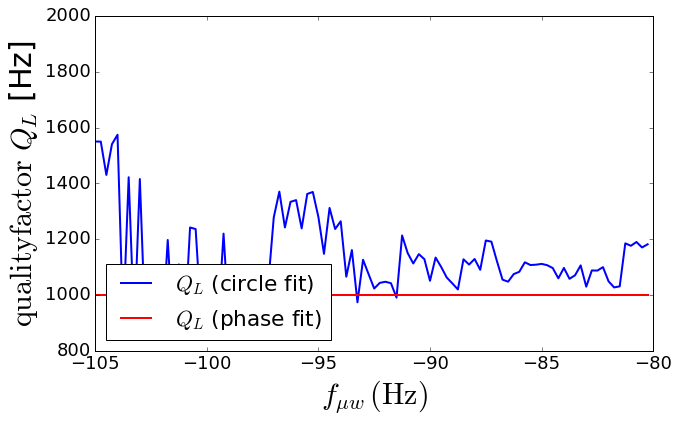

In [50]:
fig, axes = plt.subplots(figsize = (10,6))
axes.plot(power_lowP,Qload_cf_lowP, label = r'$Q_L$ (circle fit)', lw = 2, color = 'blue')
axes.plot(power_lowP,Qload_pf_lowP, label = r'$Q_L$ (phase fit)', lw = 2, color = 'red')
axes.set_ylabel(r'$\mathrm{quality factor}\,\,Q_L$ [Hz]', fontsize = labelsize)
axes.set_xlabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize= labelsize)
axes.legend(loc = 3)
axes.set_ylim(800, 2000)

In [51]:
fres_cf_lowP = np.array(fres_cf_lowP)
mask_lowP = []
for i in range(len(fres_cf_lowP)):
    low = 8.8e9
    high = 9.e9
    mask_lowP.append(np.any((fres_cf_lowP[i] > high, fres_cf_lowP[i] < low), axis = 0))

In [ ]:
fres_mask_lowP = np.ma.masked_array(fres_cf_lowP,mask_lowP)

In [ ]:
fig, axes = plt.subplots(figsize = (10,6))
axes.plot(power_lowP,fres_mask_lowP, label = 'fres (circle fit)', lw = 2, color = 'blue')
axes.plot(power_lowP,fres_pf_lowP, label = 'fres (phase fit)', lw = 2, color = 'green')
axes.set_ylabel(r'$\mathrm{res.\,freq.} f$ [Hz]', fontsize = labelsize)
axes.set_xlabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize= labelsize)

## duffing non-linearity alpha & participation ratio

In [ ]:
a, b, c, d = np.polyfit((n-n[0]),fres_mask_lowP-fres_mask_lowP[0], 3)
print c

In [ ]:
gamma_0 = (np.abs(2*np.pi*c)/alpha_0)**(1/3.)
print gamma_0

In [ ]:
L_s = gamma_0 * cpw_res._L
print 'LJ = {} H, L_res = {}'.format(L_s, cpw_res._L)

In [ ]:
I_c = (2*np.pi*(L_s)/phi_0)**(-1)/2
print I_c

In [ ]:
aa, ba, ca, da = np.polyfit((n-n[0]),fres_pf_lowP-fres_pf_lowP[0], 3)
print ca

In [ ]:
gamma_0a = (np.abs(2*np.pi*ca)/alpha_0)**(1/3.)
print gamma_0a

In [ ]:
L_sa = gamma_0a * cpw_res._L
print L_sa, cpw_res._L

In [ ]:
I_ca = (2*np.pi*(L_sa)/phi_0)**(-1)/2
print I_ca

In [ ]:
fig, axes = plt.subplots(figsize = (15,6))
axes.plot(n,(fres_pf_lowP-fres_pf_lowP[0])/1000, label = r'data (phase fit)', lw = 4)
axes.plot(n, (aa*(n-n[0])**3.+ba*(n-n[0])**2.+ca*(n-n[0])+da)/1000, label = r'fit', lw = 3, color = 'red')
#axes.axvline(n[0])
axes.set_ylabel(r'$\mathrm{freq.\,shift}\,\,\delta f$ [kHz]', fontsize = labelsize)
axes.set_xlabel(r'$\mathrm{number\,\,of\,\,photons}\,\,n = |A|^2 $', fontsize = labelsize)
axes.axvline(n[0], color = 'black', ls = '-.', lw = 2)
axes.legend()

In [ ]:
fig, axes = plt.subplots(figsize = (15,6))
axes.plot(n,(fres_mask_lowP-fres_mask_lowP[0])/1000, label = r'data (circle fit)', lw = 4)
axes.plot(n, (a*(n-n[0])**3.+b*(n-n[0])**2.+c*(n-n[0])+d)/1000, label = r'fit', lw = 3, color = 'red')
#axes.axvline(n[0])
axes.set_ylabel(r'$\mathrm{freq.\,shift}\,\,\delta f$ [kHz]', fontsize = labelsize)
axes.set_xlabel(r'$\mathrm{number\,\,of\,\,photons}\,\,n = |A|^2 $', fontsize = labelsize)
axes.axvline(n[0], color = 'black', ls = '-.', lw = 2)
axes.legend()

In [ ]:
fig, axes = plt.subplots(figsize = (10,6))
axes.plot(power_lowP, chi_sqr_lowP, lw = 2)
axes.set_ylabel(r'$\chi^2$', fontsize = labelsize)
axes.set_xlabel(r'$P_{\mu w}\,(\mathrm{dBm})$', fontsize= labelsize)

In [ ]:
res_data_lowP.plot(power_lowP,res_data_lowP._freq,res_data_lowP._phase_spec_n,fres_mask_lowP)

In [ ]:
res_data_lowP.plot(power_lowP,res_data_lowP._freq,res_data_lowP._amp_spec,fres_mask_lowP)

In [ ]:
res_data_lowP.plot(power_lowP,res_data_lowP._freq,res_data_lowP._amp_spec_n,fres_mask_lowP)

In [ ]:
fig, axes = plt.subplots(2,1, figsize = (16,10))
for i in range(len(power_lowP)):
        axes[0].plot(f_data_lowP, np.angle(z_data_raw_lowP[i]))
        axes[1].plot(f_data_lowP, np.absolute(z_data_raw_lowP[i]))

In [ ]:
amp = np.array(data['/entry/data0/amplitude'])

In [ ]:
attenuation = 90
power = np.array(data['/entry/data0/power (dbm)'])
power -= attenuation

In [ ]:
freq = np.array(data['/entry/data0/frequency'])

In [ ]:
data_mask_amp = powerspec.data_mask(1,amp)

In [ ]:
amp_n = powerspec.normalize_amp(amp.T,data_mask_amp)

In [ ]:
amp_spec = powerspec._spec(amp_n,data_mask_amp)

In [ ]:
powerspec.plot(power,freq,amp_spec.T)

In [ ]:
#powerspec.plot_save('_amp')

In [ ]:
phase = np.array(data['/entry/data0/phase'])

In [ ]:
dm_phase = powerspec.data_mask_phase(phase)

In [ ]:
#phase_n = powerspec.phaseshift(phase.T,dm_phase)     #phase shift not neccessary for new data format h5

In [ ]:
phase_spec = powerspec._spec(phase.T,dm_phase)

In [ ]:
powerspec.plot(power,freq,phase_spec)

In [ ]:
#powerspec.plot_save('_phase')

In [ ]:
labelsize = 20

In [ ]:
len(amp[100])

In [ ]:
fig, axes = plt.subplots(figsize=(15,7))
#axes.set_position([0.2,0.15,0.75,0.8])
axes.plot(freq,amp_n.T[100], 'k', label ='symmetric', color = 'blue', lw = 2)
axes.set_xlim(freq[0], freq[-1])
#axes.set_ylim(y_val[0], y_val[-1])
axes.set_ylabel(r'$S11\,\mathrm{amplitude}\,(\mathrm{a.u.})$', fontsize= labelsize)
axes.set_xlabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize= labelsize)
#axes.axis([-0.75,0.75,0,max_freq+delta])
#axes.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.show()